In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow_text as text

In [2]:
from glob import glob
f = glob('./data/*.csv')
f

['./data\\train_data.csv',
 './data\\train_data_append_label.csv',
 './data\\train_data_append_sentence.csv',
 './data\\val_data.csv',
 './data\\val_data_append_sentence.csv']

In [3]:
import pandas as pd
df=pd.read_csv(f[2])
test_df = pd.read_csv(f[4])
df.head()

,id,start,end,text,label
0,e853d357af5049768f2b67db91df24d6,0,52,[SEP][SEP] 26 IN THE HIGH COURT OF DELHI AT NE...,ANALYSIS
1,6d010bb61a8a43c19e6ee9d1043ffad9,96,122,[SEP] 26 IN THE HIGH COURT OF DELHI AT NEW DEL...,ANALYSIS
2,37cfdb87ac654fd987d5f6ac6b8ac170,122,197,26 IN THE HIGH COURT OF DELHI AT NEW DELHI[SE...,ANALYSIS
3,1097d8d9896944e1a33f60f921af2695,197,231,Decided on 15th May 2017[SEP] W P CRL 1021 201...,ANALYSIS
4,6238617acbf342b580984fd6ee002d5f,231,550,W P CRL 1021 2013 DEPARTMENT OF CUSTOMS [SEP]...,ANALYSIS


In [4]:
train_df = df.sample(frac = 0.8)
val_df = df.drop(train_df.index)

In [5]:
train_sentences = train_df["text"].tolist()
test_sentences = test_df["text"].tolist()
val_sentences = val_df["text"].tolist()

LABEL PREPROCESSING, CHANGING IT TO ONE HOT ENCODED ARRAY OR LABEL ENCODED

In [6]:
# labels to numbers
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_onehot = one_hot_encoder.fit_transform(train_df["label"].to_numpy().reshape(-1,1))
val_labels_onehot = one_hot_encoder.transform(val_df["label"].to_numpy().reshape(-1,1))
test_labels_onehot = one_hot_encoder.transform(test_df["label"].to_numpy().reshape(-1,1))

In [7]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["label"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["label"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["label"].to_numpy())

classes = label_encoder.classes_
classes

array(['ANALYSIS', 'ARG_PETITIONER', 'ARG_RESPONDENT', 'FAC', 'ISSUE',
       'NONE', 'PREAMBLE', 'PRE_NOT_RELIED', 'PRE_RELIED', 'RATIO', 'RLC',
       'RPC', 'STA'], dtype=object)

In [8]:
#average length of a sentences
np.mean([len(sentence.split())for sentence in train_sentences])

84.2938237965486

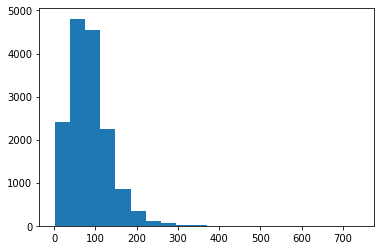

In [9]:

plt.hist([len(sentence.split())for sentence in train_sentences], bins=20);

In [10]:
#Top 95 percentile sentence of length is 55 words long
np.percentile([len(sentence.split())for sentence in train_sentences],95)

172.34999999999854

In [11]:
#TOKEN VECTORIZATION
max_tokens = 68000
output_seq_len =55
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length = output_seq_len)

In [12]:
text_vectorizer.adapt(train_sentences)

In [13]:
#TOKEN EMBEDDING
token_embed = layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()),
                               output_dim=128,
                               mask_zero =True,
                               name ="token_embedding")

Characters pre-preprocessing


In [14]:
#creating character level splits
def split_chars(text):
  return " ".join(list(text))
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
mean_chars_len=149
output_seq_char_len = 290

In [15]:
import string
alphabet = string.ascii_lowercase+ string.digits+string.punctuation

In [16]:
## CHARACTER VECTORIZATION
NUM_CHAR_TOKENS = len(alphabet) + 2 
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")


char_vectorizer.adapt(train_chars)

In [17]:
#CHARACTER EMBEDDING
char_embed = layers.Embedding(input_dim = len(char_vectorizer.get_vocabulary()),
                              output_dim= 25,
                              mask_zero = True,
                              name = "char_embed")

In [18]:
bert_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
bert_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [19]:
import tensorflow_hub as hub
"""bert_preprocess_model = hub.KerasLayer(bert_preprocess,trainable=False,name='bert_preprocessor')
bert_model = hub.KerasLayer(bert_url,trainable=True,name='bert_encoder')"""

"bert_preprocess_model = hub.KerasLayer(bert_preprocess,trainable=False,name='bert_preprocessor')\nbert_model = hub.KerasLayer(bert_url,trainable=True,name='bert_encoder')"

In [20]:
## create an embedding layer from tensorflow hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=True,
                                        name="universal_sentence_encoder")

In [21]:
# one hot encode the line number, since most of them are 15 lines long, we will go with 15
"""train_line_numbers_onehot = tf.one_hot(train_df["line_number"].to_numpy(), depth = 15)
val_line_numbers_onehot = tf.one_hot(val_df["line_number"].to_numpy(), depth = 15)
test_line_numbers_onehot = tf.one_hot(test_df["line_number"].to_numpy(), depth = 15)"""

'train_line_numbers_onehot = tf.one_hot(train_df["line_number"].to_numpy(), depth = 15)\nval_line_numbers_onehot = tf.one_hot(val_df["line_number"].to_numpy(), depth = 15)\ntest_line_numbers_onehot = tf.one_hot(test_df["line_number"].to_numpy(), depth = 15)'

In [22]:
#same idea but for total_lines
"""train_total_lines_onehot = tf.one_hot(train_df["total_lines"].to_numpy(), depth = 20)
val_total_lines_onehot = tf.one_hot(val_df["total_lines"].to_numpy(), depth = 20)
test_total_lines_onehot = tf.one_hot(test_df["total_lines"].to_numpy(), depth = 20)"""

'train_total_lines_onehot = tf.one_hot(train_df["total_lines"].to_numpy(), depth = 20)\nval_total_lines_onehot = tf.one_hot(val_df["total_lines"].to_numpy(), depth = 20)\ntest_total_lines_onehot = tf.one_hot(test_df["total_lines"].to_numpy(), depth = 20)'

In [23]:
## after creating character and words embeddings, time to build multi-modal model (hybrid embedding model)

# 1-token (words) inputs
token_inputs = layers.Input(shape =[], #hub layer
                            dtype= tf.string, name ="input")

#token_preprocess = bert_preprocess_model(token_inputs)
#token_embeddings = bert_model(token_preprocess)
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output= layers.Dense(128, activation="relu")(token_embeddings)#token_embeddings['pooled_output'])
token_model = tf.keras.Model(inputs=token_inputs,outputs=token_output)

# 2-char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) 
char_model = tf.keras.Model(inputs=char_inputs,outputs=char_bi_lstm)

## 3-concatenate 1, 2
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])
token_char_concat_output = layers.Dense(256, activation="relu")(token_char_concat)
token_char_concat_output = layers.Dropout(0.5)(token_char_concat)

### 4-create model for line_number
#line_number_input = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
#line_number_output = layers.Dense(32,activation="relu")(line_number_input)
#line_number_model = tf.keras.Model(inputs=line_number_input,
                                   #outputs=line_number_output)
## 5-create model for total lines
#total_lines_input = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
#total_lines_output = layers.Dense(32,activation="relu")(total_lines_input)
#total_lines_model = tf.keras.Model(inputs=total_lines_input,
                                   #outputs=total_lines_output)

## 6-concatenate 3,4,5
#char_token_lines_concat = layers.Concatenate(name="char_token_lines_concat")([line_number_model.output, 
                                                                              #total_lines_model.output,
                                                                              #token_char_concat_output #didnt use .output because its not a model
                                                                              #])


## 7-create the output layers
output_layer = layers.Dense(len(classes), activation ="softmax", name="output_layer")(token_char_concat_output)

model = tf.keras.Model(inputs =[token_model.input, char_model.input],
                       outputs = output_layer,
                       name="model")
"""output_layer = layers.Dense(len(classes),activation='softmax',name='output_layer')(token_embeddings['pooled_output'])

model = tf.keras.Model(inputs = token_inputs,
                       outputs = output_layer,
                       name="model")
"""

'output_layer = layers.Dense(len(classes),activation=\'softmax\',name=\'output_layer\')(token_embeddings[\'pooled_output\'])\n\nmodel = tf.keras.Model(inputs = token_inputs,\n                       outputs = output_layer,\n                       name="model")\n'

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 input (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['input[0][0]']              

In [25]:
## plot the model
from tensorflow.keras.utils import plot_model
plot_model(model , show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [26]:
model.compile(loss =tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
              optimizer="adam",
              metrics =["accuracy"])

In [27]:
# combine chars, tokens, and numbers as an input 
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # train_tokens,train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_onehot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(8).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_onehot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(8).prefetch(tf.data.AUTOTUNE)

In [28]:
len(train_sentences)

15414

In [29]:
int(len(val_pos_char_token_dataset)*0.1)

48

In [ ]:
model_history = model.fit(train_pos_char_token_dataset,
                              #steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=15,
                              validation_data=val_pos_char_token_dataset)
                              #validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/15
   8/1927 [..............................] - ETA: 1:27:53 - loss: 2.5370 - accuracy: 0.2188

In [ ]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences,test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_onehot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_pred_probs = model.predict(test_pos_char_token_dataset)
model_preds = tf.argmax(model_pred_probs, axis =1)

In [ ]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,classification_report
print(classification_report(y_true= test_labels_encoded, y_pred=model_preds))

In [ ]:
def calculate_results(y_true, y_pred):
	""""
	EVALUATE ACCURACY, PRECISION, RECALL, F1 SCORE
	"""
	model_accuracy = accuracy_score(y_true, y_pred) * 100
	model_precision, model_recall, model_f1,_ = precision_recall_fscore_support(y_true, y_pred,average="weighted")
	model_results = {"accuracy":model_accuracy,
					 "precision":model_precision,
					 "recall" :model_recall, 
					 "f1":model_f1}
	return model_results
calculate_results(y_true= test_labels_encoded, #label array outputted from the label encoder of sklearn
                  y_pred=model_preds)